<a href="https://colab.research.google.com/github/jecsakf/deep_learning/blob/main/Harmadik_hazi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. házi feladat

**Feldat:** A harmadik házi feladat keretében, egy adott járműtípust ábrázoló képekről a jármű kiszegmentálását kell konvolúciós hálóval megtanulni. Mivel az adott járműtípushoz nem áll rendelkezésünkre sok pixelszintű annotációt tartalmazó mintapélda, ezért transfer learning-et fogunk alkalmazni. Így tehát, a szegmentációra való betanítást nem egy véletlenszerűen inicializált hálón kezdjük el, hanem egy másik feladaton előtanított hálón. Az előtanítási feladat 10 kategóriába sorolt, különböző állatokat és járműveket ábrázoló képek klasszifikációja lesz. Ehhez a feladathoz jóval több címkézett adat rendelkezésünkre áll.

**Adatbázis:** A feladat során a Pascal VOC adatbázis egy csökkentett felbontású részhalmazával kell dolgozni. Az adatbázisban tíz kategóriába (négy fajta jármű és hat fajta állat) sorolt objektumokról készült képek vannak. Az adatbázis két részből áll:

- A klasszifikációs rész két pickle fájlt tartalmaz, különböző kategóriájú képek és a hozzájuk tartozó kategóriacímkék találhatók meg benne.

- A szegmentációs rész is két pickle fájlból áll. Az egyikben képek, míg a másikban a hozzájuk tartozó pixelszintű szegmentációs címkék találhatók. 

**Az előtanítási feladat:** Az előtanítási feladatban képek multiclass klasszifikációját tanuljuk meg egy hagyományos konvolúciós háló segítségével. Mivel a célfeladatunk egy adott járműtípus kiszegmentálása lesz (hallgatónként változó, hogy melyik), alapvetően járművekre szeretnénk koncentrálni az előtanítás során is. Négy kategóriát alakítunk ki az eredetileg tíz kategóriába sorolt képekből: a négy eredeti jármű kategóriából azt a hármat választjuk ki, amelyek nincsenek a célfeladatunkban. 

A negyedik, szegmentációhoz használt járműfajtát az előtanítás során nem használjuk fel. Ezt azért tesszük, mert a képek egy része megtalálható mind a klasszifikációs, mind a szegmentációs adatbázisban, nincsenek összepárosítva, így ahhoz, hogy elkerüljük azt az esetleges szituációt, hogy a szegmentációs feladat során a teszthalmazba az előtanítás közben látott tanítóminták kerüljenek, inkább teljesen kihagyjuk ezt a kategóriát az előtanításból.

Az előtanítás negyedik kategóriája a három fajta jármű mellett az összes állatos kép lesz, egyetlen közös kategóriába sorolva.

**A célfeladat:** A célfeladat bináris szegmentáció lesz az előtanításkor kihagyott járműkategóriára. A szegmentációs adatbázisból kinyerjük azokat a képeket, melyeken legalább egy pixelnyi terjedelemben megtalálható ez a járműtípus, majd az előtanított hálót átalakítással szegmentációra alkalamssá tesszük (Fully-Convolutional Network architektúra). Az így kapott hálót tanítjuk tovább a képeink minden pixelére megbecsülni, hogy az a pixel az adott járműtípust, vagy bármi mást ábrázol. (Azaz, lényegében pixelenkénti bináris klasszifikációt végzünk.)

**Instrukciók:** 

A házi feladat több részfeladatból áll (A - Q), melyek egymásra épülnek. A feladat automatikus tesztelőszkripttel rendelkezik. Éppen ezért, **ne változtasd meg a notebook struktúráját**, ne szedd több részre, illetve ne módosítsd a megírt részeket, csak a megoldásaidat írd be a megfelelő helyre, különben nem fogjuk tudni értékelni. A megoldások az `# Implement your solution BELOW` és `# Implement your solution ABOVE` sorok közé írandók. Ha a megoldott részfeladatok futtatásakor a "Tester: .... OK" felirat megjelenik, _feltehetően_ jó a megoldás.

**Kikötés:** Ahol csak lehet, hatékony megoldásokat várunk. Ciklust, illetve hasonló, nem hatékony, nem vektorizált konstrukciót csak akkor fogadunk el, ha kis számú iteráció történik (pl. kategóriák mentén). Egy kivétel: a képek átméretezésénél, külső könyvtár átméretező függvénye hívható ciklusban a képekre, de az átméretezés is megoldható ciklus nélkül, egyébként.

Tesztelő szkript letöltése, importok.

In [ ]:
# Download tester
!rm hw3_tester.py
!wget http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/hw3_tester.py

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers

# import tester after importing tensorflow, to make sure correct tf version is imported
from hw3_tester import Tester


--2021-06-21 20:57:12--  http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/hw3_tester.py
Resolving nipg12.inf.elte.hu (nipg12.inf.elte.hu)... 157.181.160.172
Connecting to nipg12.inf.elte.hu (nipg12.inf.elte.hu)|157.181.160.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24785 (24K) [text/plain]
Saving to: ‘hw3_tester.py’

hw3_tester.py       100%[===================>]  24.20K  --.-KB/s    in 0.03s   

2021-06-21 20:57:13 (927 KB/s) - ‘hw3_tester.py’ saved [24785/24785]



A tesztelőszkript a részedre kiosztott feladatok helyességét fogja tesztelni. Ehhez az alábbi kódblokkban, a Tester példányosításakor, paraméterként a Neptun-kódodat kell megadni egy sztringként, pl: 
`tester = Tester('DK7UAQ')`, majd futtatni kell a blokkot.


In [ ]:
tester = Tester('BQ2RKO')

Letöltjük az előfeldolgozott adatbázist, ha nem található meg a futtatókörnyezet tárhelyén. A képeket tartalmazó fájlok együttes mérete 400 megabájt körüli, 1-2 percet igénybe vehet a letöltése a futtatókörnyezet tárhelyére. Előfordul, hogy a tárhelyen elérhetők maradnak a fájlok akkor is, ha a futtatókörnyezetről lekapcsolódunk, de ez nem garantált.

In [ ]:
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/class_data.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/class_label.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/seg_data.pkl
!wget -nc -P VOC2012/ http://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc21_p1_hw3/VOC2012/seg_label.pkl

File ‘VOC2012/class_data.pkl’ already there; not retrieving.

File ‘VOC2012/class_label.pkl’ already there; not retrieving.

File ‘VOC2012/seg_data.pkl’ already there; not retrieving.

File ‘VOC2012/seg_label.pkl’ already there; not retrieving.



Az adatbázis beolvasása.

In [ ]:
CAT_NAMES = ['aeroplane', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'sheep']

with open('VOC2012/class_data.pkl', 'rb') as f:
    arr_cl_data = pickle.load(f)
with open('VOC2012/class_label.pkl', 'rb') as f:
    arr_cl_labs = pickle.load(f)
with open('VOC2012/seg_data.pkl', 'rb') as f:
    arr_seg_data = pickle.load(f)
with open('VOC2012/seg_label.pkl', 'rb') as f:
    arr_seg_labs = pickle.load(f)
    
print("Shape of classification image array:", arr_cl_data.shape)
print("Shape of classification label array:", arr_cl_labs.shape)
print("Shape of segmentation image array:", arr_seg_data.shape)
print("Shape of segmentation label array:", arr_seg_labs.shape)

Shape of classification image array: (6638, 128, 128, 3)
Shape of classification label array: (6638, 10)
Shape of segmentation image array: (1735, 128, 128, 3)
Shape of segmentation label array: (1735, 128, 128)


Az `arr_cl_data` tömb alakja (n_cl_images, size_y, size_x, n_channels=3), a klasszifikációhoz használandó RGB kódolású képeket tartalmazza 10 kategóriából válogatva. Az `arr_cl_labs` címketömb az ezeken a képeken megtalálható objektumok kategória-azonosítóit tartalmazza. Alakja (n_cl_images, n_categories=10). Minden képre 10 darab számot tárol (nullát, vagy egyet), aszerint, hogy az adott kategóriájú objektum előfordul-e a képen. Egy képen többféle objektum is megtalálható lehet, ekkor nyilván több egyes számjegy van a címketömb adott képhez tartozó sorában.

Az `arr_seg_data` tömb az `arr_cl_data` tömbhöz hasonló formátumú, de jóval kevesebb kép van benne, alakja (n_seg_images, size_y, size_x, n_channels=3). Ezekhez a képekhez pixel szintű annotáció is tartozik, ami az `arr_seg_labs` tömbben van eltárolva, így szegmentálás betanításához használhatók. A `arr_seg_labs` tömb alakja (n_seg_images, size_y, size_x). Minden pixelre egy `uint8` típusú számot tárol, ami a következő lehet: 0 - háttér, 1 .. 10 - valamelyik kategória a 10 közül, 255 - kategóriák közti határvonal.

Érdemes odafigyelni a kategóriák azonosítóinál: a klasszifikációs címketömbben az egyes kategóriák a 0-tól 9-es indexeken vannak (lévén 10 hosszú a tengely), míg a szegmentációs címkék pixelei ugyanezeket a kategóriákat 1-től 10-es értékekkel kódolják.

###**A**: Képek kirajzolása a klasszifikációs adatbázisból

Elsőként belenézünk a letöltött klasszifikációs adatbázis tartalmába. Rajzolj ki néhány képet az `arr_cl_data` tömbből és írd ki az adott kép kategóriájának nevét a kirajzolt képek alá/fölé! A kategórianevek az előző kód blokkban a `CAT_NAMES` listában meg lettek adva.

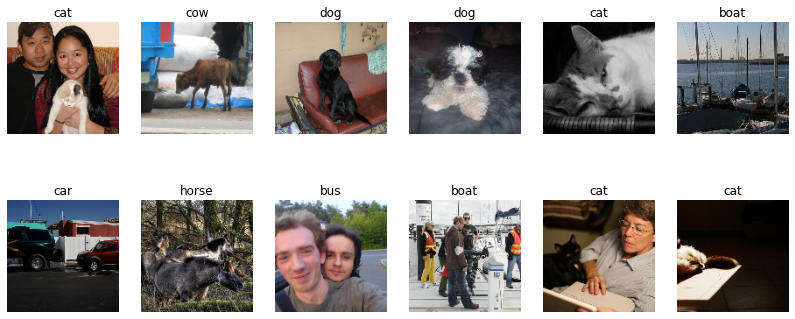

In [ ]:
# implement your solution BELOW

sample_idxs = np.random.choice(arr_cl_data.shape[0], size=12)

fig, axs = plt.subplots(2,6)
fig.set_figwidth(14)
fig.set_figheight(6)

for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(arr_cl_data[sample_idxs[plot_idx]])
    text = CAT_NAMES[np.argmax(arr_cl_labs[sample_idxs[plot_idx]])]
    axs[plot_idx//6, plot_idx%6].axis("off")
    axs[plot_idx//6, plot_idx%6].set_title(str(text))

# implement your solution ABOVE

###**B**: Új kategóriák definiálása a klasszifikációhoz

Mivel járműveket szeretnénk tudni felismerni/szegmentálni, a multi-class klasszifikációban ezekre a kategóriákra fogunk koncentrálni. A klasszifikációs feladatban 4 kategória egyikébe kell a képeinket megtanulni besorolni. A jármű kategóriákat megtanuljuk elkülöníteni egymástól, a fennmaradó kategóriákat "other" címen egy kategóriába soroljuk. A klasszifikációhoz elkülönítendő 4 kategória tehát a következő:

- **B/1**: ['boat', 'bus', 'car', {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'}]
- **B/2**: ['aeroplane', 'bus', 'car', {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'}]
- **B/3**: ['aeroplane', 'boat', 'car', {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'}]
- **B/4**: ['aeroplane', 'boat', 'bus', {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'}]

(Később, a szegmentációs feladatban mindenkinek az egyetlen számára kimaradt jármű kategóriát kell tudnia tanulni szegmentálni, az összes másik kategória és a háttér ellenében.)

Készítsd el a `sample_idxs_ls` listát! A lista legyen 4 hosszú, az elemei a fent megjelölt új kategóriában megtalálható képek/címkék index-tömbjei. Az index tömbök elemei az `arr_cl_data` és `arr_cl_labs` tömbökből a megfelelő kategóriájú elemeket hivatkozzák. Például a lista első eleme a 'boat' kategóriába tartozó képek indexeit tartalmazó tömb, a lista utolsó eleme a {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'} kategóriák egyikébe tartozó képek indexeit tartalmazó tömb, stb. Csak azoknak a képeknek az indexeit válogasd be a `sample_idxs_ls` listába, amelyeken pontosan egy kategória szerepel! Azokat a képeket, melyeken több kategória szerepel egyszerre, nem fogjuk felhasználni a klasszifikációs feladatban.

Mivel a jarművek gyakori képi mintázatait szeretnénk a leginkább megtanulni felismerni, ezért szükséges, hogy a betanításhoz használt adatbázis elemei közt a járművek legyenek többségben. Az utolsó 'other' kategória az adatbázisunkban felülreprezentált, túl sok elem esik ebbe a kategóriába, így ezeknek csak egy részét tartjuk meg. Válassz **véletlenszerűen** 1000 indexet az utolsó 'other' kategória indexei közül és csak ezek kerüljenek bele a `sample_idxs_ls[-1]` tömbbe!

In [ ]:
# implement your solution BELOW
one_cat = np.sum(arr_cl_labs, axis=1) == 1
x_one = arr_cl_data[one_cat]
y_one = arr_cl_labs[one_cat]

cat_idxs = np.argmax(y_one, axis=1)
airp_cat = np.asarray(np.where(cat_idxs == 0)).reshape(-1)
boat_cat = np.asarray(np.where(cat_idxs == 2)).reshape(-1)
car_cat = np.asarray(np.where(cat_idxs == 4)).reshape(-1)
other_cat = np.asarray(np.where(np.in1d(cat_idxs,np.array([1,5,6,7,8,9])))).reshape(-1)
other_cat = np.random.choice(other_cat, size=1000)

sample_idxs_ls = [airp_cat, boat_cat, car_cat, other_cat]
# implement your solution ABOVE

print("Category shapes:", [cat_samples.shape for cat_samples in sample_idxs_ls])

tester.test('cl_categories', sample_idxs_ls)

Category shapes: [(636,), (476,), (881,), (1000,)]
Tester: Classifier new categories OK


###**C**: A klasszifikációhoz felhasználandó adatok kiválogatása
A `sample_idxs_ls` tömbök listájában előállítottuk, hogy melyik kategóriába melyik képek/címkék tartoznak az eredeti (`arr_cl_data` és `arr_cl_labs`) tömbökből. Az előállított indextömböket az `arr_cl_data` és `arr_cl_labs` tömbök indexelésére használva készítsd el a képeket és címkéket tartalmazó `xs` és `ys` tömböket, ahol `xs` alakja (n_cl_good_images, size_y, size_x, n_channels=3) és `ys` alakja (n_cl_good_images,). Utóbbi az új kategóriák indexeit tartalmazza (pl. B/4. feladat esetén 'aeroplane' -> 0, 'boat' -> 1, 'bus' -> 2, 'other' -> 3)!

(Itt "n_cl_good_images" a `sample_idxs_ls`-beli tömbök hosszának összege, azaz a felhasznált képek száma az összes kategóriából.)


In [ ]:
# implement your solution BELOW
n_cl_good_images = sample_idxs_ls[0].shape[0] + sample_idxs_ls[1].shape[0] + sample_idxs_ls[2].shape[0] + sample_idxs_ls[3].shape[0]
all_idxs = np.concatenate((sample_idxs_ls[0],sample_idxs_ls[1]), axis=0)
all_idxs = np.concatenate((all_idxs,sample_idxs_ls[2]), axis=0)
all_idxs = np.concatenate((all_idxs,sample_idxs_ls[3]), axis=0)
xs = arr_cl_data[one_cat]
xs = xs[all_idxs]

tmp = arr_cl_labs[one_cat]
tmp[sample_idxs_ls[0]] = 0
tmp[sample_idxs_ls[1]] = 1
tmp[sample_idxs_ls[2]] = 2
tmp[sample_idxs_ls[3]] = 3

ys = np.max(tmp, axis=1)
ys = ys[all_idxs]
# implement your solution ABOVE

tester.test('cl_dataset_creation', xs, ys)

Tester: Classifier dataset OK


###**D**: Keverés, normalizálás és felbontás tanító-, validációs- és teszthalmazra

- Keverjük meg konzisztensen a képeket (`xs`) és a kategóriacímkéket (`ys`). Ez szükséges, hiszen a két tömböt valószínűleg úgy állítottuk elő az előző kódblokkban, hogy a kategóriacímkék sorban következnek egymás után, így a tanító-, validációs- és teszthalmazra való felbontásnál előfordulna olyan kategória, amelyik csak az egyik halamzban lenne jelen.
- Mivel az input változók nagyságrendje azonos (0..255), így ezúttal nem fogjuk a hagyományos változónként független min-max/mean-std skálázást használni. Azonban, a gradiens visszaterjesztés tulajdonságai miatt nem jó, ha az input, vagy a köztes reprezentációk nagyságrendje túl kicsi, vagy túl nagy. Ezért, lineárisan skálázva transzformáljuk a [0,255] intervallumon található pixelértékeket [0,1] intervallumra. A skálázás előtt szükséges az eredetileg `uint8` típusú pixelértékeket lebegőpontossá (`float32`) konvertálni.
- Bontsuk fel tanító-, validációs- és teszthalmazra a két tömböt. Használjunk 70%/15%/15%-os felosztást. Állítsuk elő így az `x_train`, `x_val`, `x_test` inputokat (képeket) és `y_train`, `y_val`, `y_test` címkéket tartalmazó tömböket!

In [ ]:
# implement your solution BELOW
random = np.random.permutation(xs.shape[0])
xs = xs[random]
ys = ys[random]

xs = xs.astype(np.float32)/255

val_offset = int(xs.shape[0]*0.7)
test_offset = int(xs.shape[0]*0.85)

x_train = xs[:val_offset]
x_val = xs[val_offset:test_offset]
x_test = xs[test_offset:]

y_train = ys[:val_offset]
y_val = ys[val_offset:test_offset]
y_test = ys[test_offset:]

# implement your solution ABOVE

print("Training set shapes:", x_train.shape, y_train.shape)
print("Validation set shapes:", x_val.shape, y_val.shape)
print("Test set shapes:", x_test.shape, y_test.shape)

tester.test('cl_dataset_split', x_train, x_val, x_test, y_train, y_val, y_test)

Training set shapes: (2095, 128, 128, 3) (2095,)
Validation set shapes: (449, 128, 128, 3) (449,)
Test set shapes: (449, 128, 128, 3) (449,)
Tester: Classifier dataset split OK


###**E**: Véletlen választott kép-címke párok kirajzolása/kiírása

Győződj meg róla, hogy nem történt-e a keverés során hiba és továbbra is minden képhez megfelelő (új kategória-felosztás szerinti) címke tartozik.

Rajzolj ki néhány **véletlenszerűen választott** képet az `x_train`, `x_val`, `x_test` tömbök egyikéből és írasd ki a képek alatt/felett a képekhez tartozó új kategória indexét (0, 1, 2 vagy 3)!

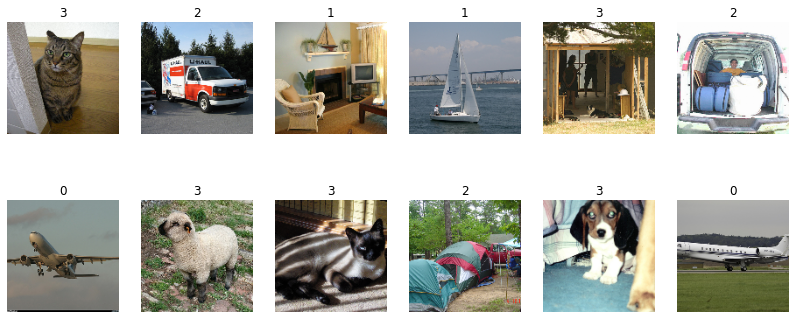

In [ ]:
# implement your solution BELOW

check_idxs = np.random.choice(x_test.shape[0], size=12)

fig, axs = plt.subplots(2,6)
fig.set_figwidth(14)
fig.set_figheight(6)

for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(x_test[check_idxs[plot_idx]])
    text = y_test[check_idxs[plot_idx]]
    axs[plot_idx//6, plot_idx%6].axis("off")
    axs[plot_idx//6, plot_idx%6].set_title(str(text))

# implement your solution ABOVE

###**F**: Konvolúciós háló definiálása klasszifikációhoz

Definiálj egy konvolúciós hálót Keras-ban és add értékül a `cl_model` változónak. A háló lehetőleg kövesse a hagyományos konvolúciós architektúrát, felváltva alkalmazott konvolúciós és pooling rétegekkel, majd teljesen összekötött rétegekkel a végén. A hálónak mindenképp legyen olyan köztes rétege melynek kimenetén a heatmap-ek felbontása 16x16 pixel, ugyanis erre a rétegre fogjuk építeni a szegmentáló modellünket. 

A 11. előadás notebookban megtalálható hálóarchitektúrát nyugodtan felhasználhatod itt is, viszont az utolsó réteg mérete és aktivációs függvénye, valamint a költségfüggvény eltérő lesz. Egyrészről, a kettőnél több kategória esetén alkalmazott multi-class klasszifikációnál szokásos aktivációs- és költségfüggvényt kell alkalmaznod. Ezenkívül, érdemes lehet Max pooling rétegek helyett Average pooling rétegeket alkalmazni, magyarázatért lásd: Canvas HF3 GYIK fórum.

Bár a címkékhez a one-hot kódolást kézzel is elő lehet állítani, mi ezúttal ezt nem tesszük meg: a Keras tudja kezelni az eredeti kategóriacímke-tömböt is, ha a szokásos költség "sparse" változatát használjuk. Lásd: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

A modellt fordítsd le a `compile()` függvény segítségével!

In [ ]:
# implement your solution BELOW
cl_model = Sequential()
cl_model.add(Conv2D(20, (3,3), input_shape=(128,128, 3), activation="relu", padding="same"))
cl_model.add(AveragePooling2D((2,2)))
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(AveragePooling2D((2,2)))
cl_model.add(Dropout(0.3))
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(AveragePooling2D((2,2)))
cl_model.add(Dropout(0.3))
cl_model.add(Conv2D(40, (3,3), activation="relu", padding="same"))
cl_model.add(AveragePooling2D((2,2)))
cl_model.add(Dropout(0.3))
cl_model.add(Flatten())
cl_model.add(Dense(400, activation="relu"))
cl_model.add(Dropout(0.3))
cl_model.add(Dense(100, activation="relu"))
cl_model.add(Dense(4, activation="softmax"))

cl_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# implement your solution ABOVE

tester.test('cl_architecture', cl_model)

Tester: Classifier model architecture OK


###**G**: Input generátorok definiálása augmentáláshoz

Sajnos a néhány ezer képből álló adatbázisunkra hamar túltanulna a hálónk és nincs lehetőségünk új tanítóadatot beszerezni, így az adat-augmentálás technikájához kell fordulnunk.
Bár megtehetnénk azt is, hogy véletlenszerűen választott transzformációkkal augmentálunk egy adatbázist a betanítás előtt és ezzel az augmentált, fix méretű adatbázissal tanítunk, de ebben az esetben vagy túl sok helyet foglalna az augmentált adatbázisunk, vagy nem lenne túl változatos az, a limitált méret miatt.

Egy ügyesebb megoldás generátorok/iterátorok alkalmazása a betanításhoz. A generátorokról/iterátorokról részletesebben a _"Python tutorial - Iterátorok és generátorok"_ című notebookban lehet olvasni. A Keras-ban számunkra elérhető ImageDataGenerator egyfajta, iterátort készítő osztály, ami képes olyan iterátort visszaadni, ami egy fix méretű adatbázisból véletlenszerűen generálja le mintaelemek batch-eit (kötegeit) és azokat véletlenszerűen augmentálja is az általunk megadott paraméterek szerint. A megvalósítás hatékony, hiszen míg a GPU-n betanítjuk a modellünket, párhuzamosan, a CPU szabad kapacitását az augmentálással járó számításigényes transzformációkhoz lehet felhasználni.

Definiáld a `datagen` ImageDataGenerator példányt, melyet a betanítás során a tanító- és a validációs halmaz augmentálásához fogunk használni! Az alábbi augmentációkat végezze el:

- Elforgatás (rotate) -30 .. +30 fokkal
- Eltolás (shift) -20% .. + 20%-kal (a képmérethez képest, széltében és magasságában is)
- Tükrözés (flip) vízszintesen (függőleges tengelyre)
- A transzformációk következtében lefedetlen pixelek kitöltése: a kép ismétlésével (wrap fill_mode)
- Skálázás (zoom) 75% .. 125%-os nagyításra

Továbbá:

- **G/1**: Tükrözés függőlegesen (vízszintes tengelyre), színcsatornák fényerejének független skálázása (channel shift) -10% .. +10% közt.
- **G/2**: Nyírás (shear) -10% .. +10% közt, színcsatornák fényerejének független skálázása (channel shift)  -20% .. +20% közt.
- **G/3**: Tükrözés függőlegesen (vízszintes tengelyre), nyírás (shear) -20% .. +20% közt.

Az ImageDataGenerator példány `flow()` tagfüggvénye készíti el magát az iterátort, amiből kinyerhetjük a véletlenszerűen választott, augmentált input-output batch-eket. Ennek, paraméterül kell megadni az iterációhoz használt input és output tömböket. Készítsd el a tanító- és validáló- iterátorokat ilyen módon és add értékül őket a `train_generator` és `val_generator` nevű változóknak!

In [ ]:
# implement your solution BELOW
params = {
    'rotation_range' : 30,
    'width_shift_range' : 0.2, 
    'height_shift_range' : 0.2, 
    'vertical_flip' : True,
    'fill_mode' : 'wrap',
    'zoom_range' : [0.75,1.25],
    'horizontal_flip' : True,
    'channel_shift_range' : 0.1
}

datagen = ImageDataGenerator(**params)

train_generator = datagen.flow(x_train, y_train, batch_size=64)
val_generator = datagen.flow(x_val, y_val, batch_size=64)
# implement your solution ABOVE

tester.test('cl_datagen', datagen, train_generator, val_generator)

Tester: Classifier data generators OK


###**H**: A háló betanítása klasszifikációs feladatra

Tanítsd be a `cl_model` konvolúciós neuronhálót a klasszifikációs feladatra!

Használd a Keras Model `fit_generator()` tagfüggvényét a tanító- és validációs iterátorokkal a betanításhoz! A tanítás végeztével mérd le a modell pontosságát (accuracy) a teszthalmazon! Ehhez használd a Model `evaluate()` függvényét: ez kiszámolja az accuracy-t, ha előzőleg a megfelelő metrikát megadtad a Model lefordításakor.

**Megjegyzés**: Érdemes lehet `ModelCheckpoint` callback-et használni a betanítás közben a súlyok időnkénti kimentésére. A checkpoint-ot használva, azután már nem szükséges a hálót újból betanítani a notebook további részével való munkához, a korábbi tanítás súlyai betölthetők.

A mentett checkpoint fájlokat akár le is lehet tölteni saját gépre: így, ha megszakítod a munkát és később folytatod azt, abban az esetben, ha törlődne a futtatókörnyezet tárhelyéről a checkpoint, feltöltheted újból a lementett checkpoint fájlokat, ezáltal nem kell többször újra betanítod a klasszifikációs modellt. Ennek mikéntjéről a 11. előadás notebookban és a HF3 GYIK Canvas fórumon olvashatsz.

Checkpoint folder was not found. Training classifier...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
33/33 [==============================] - 12s 334ms/step - loss: 1.3384 - accuracy: 0.3542 - val_loss: 1.2152 - val_accuracy: 0.4521
Epoch 2/200
33/33 [==============================] - 11s 328ms/step - loss: 1.2800 - accuracy: 0.4196 - val_loss: 1.1908 - val_accuracy: 0.4677
Epoch 3/200
33/33 [==============================] - 11s 328ms/step - loss: 1.2397 - accuracy: 0.4348 - val_loss: 1.1873 - val_accuracy: 0.4610
Epoch 4/200
33/33 [==============================] - 11s 329ms/step - loss: 1.2082 - accuracy: 0.4673 - val_loss: 1.1646 - val_accuracy: 0.5078
Epoch 5/200
33/33 [==============================] - 11s 329ms/step - loss: 1.2064 - accuracy: 0.4706 - val_loss: 1.1981 - val_accuracy: 0.4922
Epoch 6/200
33/33 [==============================] - 11s 323ms/step - loss: 1.1772 - accuracy: 0.4983 - val_loss: 1.1143 - val_accuracy: 0.5457
Epoch 7/200
33/33 [==============================] - 11s 333ms/step - loss: 1.1565 - accuracy: 0.5002 - val_loss: 1.1211 - val_accuracy:

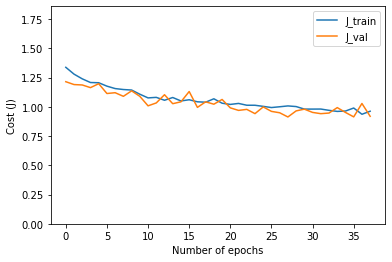

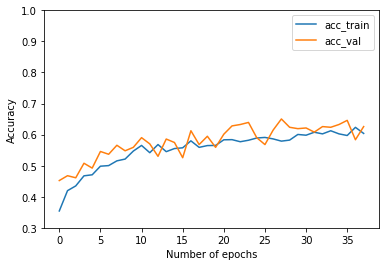

15/15 [==============================] - 0s 16ms/step - loss: 0.9292 - accuracy: 0.6325
Loss & accuracy on test set: 0.9292001724243164 0.6325166821479797
Tester: Classifier training OK


In [ ]:
# implement your solution BELOW
model_checkpoint_folder = './chkpts_annbsc_cnn_multiclasscl'
LOAD_MODEL_FROM_CHECKPOINT = False
checkpoint_name_to_load = 'cp-0040.ckpt'

if LOAD_MODEL_FROM_CHECKPOINT and os.path.isdir(model_checkpoint_folder):
    # load weights from checkpoint saved previously
    
    checkpoint_path = os.path.join(model_checkpoint_folder, checkpoint_name_to_load)
    cl_model.load_weights(checkpoint_path)
    print("Model loaded from checkpoint:", checkpoint_path)
    
else:
    # initialize weights from scratch, train weights
    print("Checkpoint folder was not found. Training classifier...")

    model_chkpt = ModelCheckpoint(os.path.join(model_checkpoint_folder, 'cp-{epoch:04d}.ckpt'), verbose=1,\
                                  save_weights_only=True, save_freq=600)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\
                                         patience=10, restore_best_weights=True)

    history = cl_model.fit_generator(generator=train_generator, validation_data=val_generator,
                    epochs=200, verbose=1,
                    callbacks=[earlystopping_callback, model_chkpt])


    tr_losses = history.history['loss']
    val_losses = history.history['val_loss']

    tr_accs = history.history['accuracy']
    val_accs = history.history['val_accuracy']

    plt.clf()
    plt.plot(tr_losses, label="J_train")
    plt.plot(val_losses, label="J_val")
    y_lim_top = np.maximum(np.amax(val_losses[2:]), np.amax(tr_losses[2:]))*1.5
    plt.ylim((0, y_lim_top))
    plt.xlabel("Number of epochs")
    plt.ylabel("Cost (J)")
    plt.legend()
    plt.show();

    plt.clf()
    plt.plot(tr_accs, label="acc_train")
    plt.plot(val_accs, label="acc_val")
    plt.ylim((0.3, 1.))
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show();
    
# test model

test_ce, test_acc = cl_model.evaluate(x_test, y_test, verbose=1)
print("Loss & accuracy on test set:", test_ce, test_acc)



# implement your solution ABOVE

tester.test('cl_training', test_acc)

###**I**: Teszthalmaz predikciók kirajzolása/kiírása

Rajzolj ki néhány **véletlenszerűen választott** képet a teszthalmazból és írasd ki a betanított modell által becsült legvalószínűbb kategóriacímke nevét!

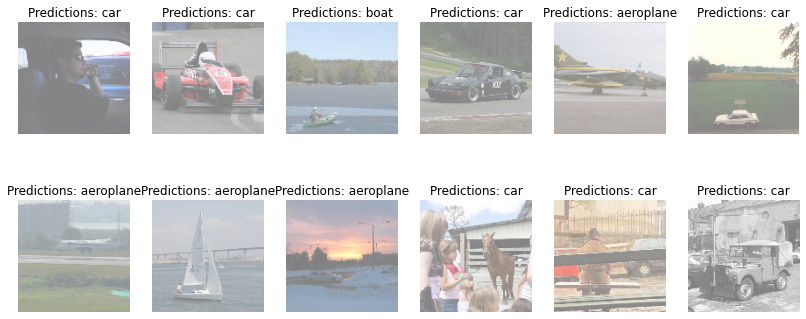

In [ ]:
# implement your solution BELOW
y_pred_test = cl_model.predict(x_test, verbose=0)
sample_idxs = np.random.choice(x_test.shape[0], size=12)

new_cat_names = ['aeroplane','boat','car','other']
fig, axs = plt.subplots(2,6)
fig.set_figwidth(14)
fig.set_figheight(6)

for plot_idx in range(12):
    axs[plot_idx//6, plot_idx%6].imshow(x_test[sample_idxs[plot_idx]]*0.5+0.5)
    axs[plot_idx//6, plot_idx%6].axis("off")
    cat_idx = np.argmax(y_pred_test[sample_idxs[plot_idx]])
    axs[plot_idx//6, plot_idx%6].set_title("Predictions: " + new_cat_names[cat_idx])

# implement your solution ABOVE

###**J**: Szegmentációhoz felhasznált kategóriához tartozó képek összegyűjtése és maszkok előállítása

Mint már korábban említve lett, a szegmentációs feladathoz a klasszifikációban nem használt kategóriára fogunk tanítani. Például, ha a **B/1.** részfeladatot kaptad és így a klasszifikációs kategóriáid a ['boat', 'bus', 'car', {'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'}] voltak, akkor a szegmentációhoz csak a kimaradt 'aeroplane' kategória elemeit kell kiválogatnod: a hálót repülőgépek szegmentálására kell finomhangolnod majd. **B/2.** esetén a kimaradt kategória a 'boat', **B/3.** esetén a 'bus', **B/4.** esetén pedig a 'car'.

Szegmentáláshoz az `arr_seg_data` képeket tartalmazó tömb és az `arr_seg_labs` hozzá tartozó pixelszintű annotációs tömb egy részhalmazával dolgozunk tovább. Kizárólag azokat a képeket fogjuk felhasználni a betanításhoz, ahol a képekhez tartozó pixelszintű címkéken legalább egy pixel erejéig megjelenik a szegmentáláshoz választott jármű kategóriánk. Azaz, például a **B/1.** opció esetén, azokat a képeket/címkéket tartjuk meg, ahol a címkében legalább egy pixel azonosítója egyezik az 'aeroplane' kategória eredeti azonosítójával. Ne feledd, az eredeti 10 kategória azonosítóit itt 1-től kezdve sorolták fel, nem nullától kezdve!

Állítsd elő az `xs_seg` és `ys_big_seg` tömböket! Az `xs_seg` tömb alakja (n_chosen_cat_seg_imgs, size_y=128, size_x=128, n_channels=3) és azokat a képeket tartalmazza, ahol a szegmentáláshoz választott kategória azonosítója legalább egy pixel erejéig megjelenik a képekhez tartozó pixelszintű maszkokon.
Az `ys_big_seg` tömb alakja (n_chosen_cat_seg_imgs, size_y=128, size_x=128) és kizárólag 0 és 1 értékeket tartalmaz. Ott lesznek benne 1 értékű pixelek, ahol az eredeti pixelszintű annotációkon a szegmentáláshoz választott kategória azonosítója található. Minden más pixel értéke 0 lesz. Azaz, röviden, bináris maszkokat állítunk elő "választott jármű" és "háttér" kategóriákkal.



In [ ]:
# implement your solution BELOW
cat_idx_bus = 4
at_least_one_pixel = np.any(arr_seg_labs == cat_idx_bus, axis=(1,2))
xs_seg = arr_seg_data[at_least_one_pixel]
ys_big_seg = np.where(arr_seg_labs[at_least_one_pixel],1,0)

# implement your solution ABOVE

tester.test('seg_dataset_creation', xs_seg, ys_big_seg)

print("Shapes of selected image and mask arrays:", xs_seg.shape, ys_big_seg.shape)

Tester: Segmentation dataset OK
Shapes of selected image and mask arrays: (150, 128, 128, 3) (150, 128, 128)


###**K**: A szegmentáláshoz címkeként használt maszkok leskálázása

Ahhoz, hogy csökkentsük a szegmentáció betanításának számításigényét, leskálázzuk a maszkokat 128x128-ról 16x16-os felbontásra. A leskálázás követendő technikáját a számodra kiosztott részfeladat határozza meg:

- **K/1.**: Leskálázás blokkonkénti átlagolással. Azaz, ha egy pixellé leskálázandó 8x8-as blokkban pl. 27 pixel világos (1) és 37 pixel sötét (0), akkor a blokkból leskálázással kapott pixel értéke 27./64.
- **K/2.**: Leskálázás bináris maszkká. Csupa világos (1) és csupa sötét (0) blokkokat világos és sötét pixelekké alakítunk. Minden olyan blokkot, ahol vegyesen találhatók világos és sötét pixelek, tetszőlegesen világos, vagy sötét pixellé skálázunk le, de nem köztes értékre.

Készítsd el az `ys_big_seg` tömb 16x16 felbontásra leskálázott változatát `ys_seg` néven! A betanításhoz szükséges, hogy a maszk tömb, az input tömbhöz hasonlóan 4 dimenziós legyen, alakja (n_chosen_cat_seg_imgs, 16, 16, 1) lesz.

In [ ]:
# implement your solution BELOW
ys_seg = np.split(ys_big_seg,16,axis=2)
ys_seg = np.stack(ys_seg, axis=1)

ys_seg = np.split(ys_seg,16,axis=2)
ys_seg = np.stack(ys_seg, axis=1)

ys_seg = np.count_nonzero(ys_seg, axis=(3,4))
ys_seg = ys_seg.reshape(150,16,16,1)
ys_seg = ys_seg.astype(np.float32)/64
# implement your solution ABOVE

tester.test('seg_mask_downscale', ys_seg)

Tester: Segmentation mask downscale OK


###**L**: Normalizálás és felbontás tanító-, validációs- és teszthalmazra

- Konvertáljuk az `xs_seg` elemeit a D) feladathoz hasonlóan `float32` típusra és a [0,1] intervallumra.
- Bontsuk fel tanító-, validációs- és teszthalmazra a két tömböt. Használjunk 70%/15%/15%-os felosztást. Állítsuk elő így az `x_seg_train`, `x_seg_val`, `x_seg_test` inputokat (képeket) és `y_seg_train`, `y_seg_val`, `y_seg_test` címkéket (maszkokat) tartalmazó tömböket!


In [ ]:
# implement your solution BELOW
xs_seg = xs_seg.astype(np.float32)/255

val_offset = int(xs_seg.shape[0]*0.7)
test_offset = int(xs_seg.shape[0]*0.85)

x_seg_train = xs_seg[:val_offset]
x_seg_val = xs_seg[val_offset:test_offset]
x_seg_test = xs_seg[test_offset:]

y_seg_train = ys_seg[:val_offset]
y_seg_val = ys_seg[val_offset:test_offset]
y_seg_test = ys_seg[test_offset:]

# implement your solution ABOVE

tester.test('seg_dataset_split', x_seg_train, x_seg_val, x_seg_test, y_seg_train, y_seg_val, y_seg_test)

Tester: Segmentation dataset split OK


###**M**: Véletlen választott kép-maszk párok kirajzolása

Ellenőrizd le, hogy megfelelő volt-e a képek és maszkok előfeldolgozása! Rajzolj ki néhány véletlenszerűen választott képet az `x_seg_train`, `x_seg_val`, `x_seg_test` tömbök egyikéből és rajzold ki alá/mellé/fölé a hozzá tartozó leskálázott maszkokat is!

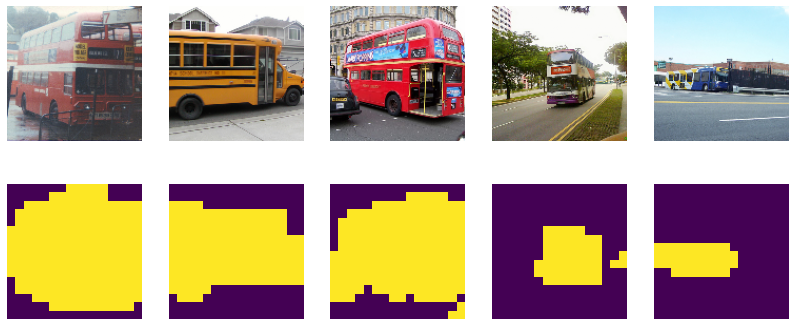

In [ ]:
# implement your solution BELOW
check_seg_idxs = np.random.choice(len(x_seg_train), 5)

plt.figure(figsize=(14, 6))
for i, ind in enumerate(check_seg_idxs):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_seg_train[ind])
  plt.axis('off')
  plt.subplot(2, 5, i+6)
  seg_img = y_seg_train[ind].copy().reshape(16,16)
  plt.imshow(np.where(seg_img>0, 255, 0))
  plt.axis('off')

# implement your solution ABOVE

###**N**: FCN (Fully-Convolutional Network) definiálása szegmentációhoz

Definiáld a `seg_model` FCN típusú neuronhálót! A modell nem kell, hogy bonyolult legyen. Nem tartalmazhat teljesen összekötött rétegeket. A háló inputja legyen a klasszifikációra tanított konvolúciós háló azon rétegének kimenete, ahol a heatmap felbontása egyezik a leskálázott maszkok méretével, azaz 16x16! A háló output felbontása is legyen ugyanekkora, utolsó rétegének aktivációs függvénye a bináris klasszifikációhoz használt függvény lehet, hiszen a bináris szegmentációval lényegében pixelenkénti bináris klasszifikációt hajtunk végre. A költségfüggvény is ennek megfelelő kell, hogy legyen.

Egy példa egyszerű FCN hálóra (az előtanított hálóban levő rétegeket nem felsorolva):
- konv. réteg 3x3-as filterrel, 40 filter, ReLU
- konv. réteg 3x3-as filterrel, 20 filter, ReLU
- dropout p=0.3
- konv. réteg 3x3-as filterrel, 1 filter, ReLU.



In [ ]:
# implement your solution BELOW
seg_model = Conv2D(40, (3,3), activation="relu", padding="same")(cl_model.layers[6].output)
seg_model = Conv2D(20, (3,3), activation="relu", padding="same")(seg_model)
seg_model = Dropout(0.3)(seg_model)
seg_model = Conv2D(1, (3,3), activation="sigmoid", padding="same")(seg_model)
seg_model = Model(inputs=cl_model.input, outputs=seg_model)

seg_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["mae"])
seg_model.summary()

# implement your solution ABOVE

tester.test('seg_architecture', seg_model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22_input (InputLayer) [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 20)      560       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 40)        7240      
_________________________________________________________________
average_pooling2d_17 (Averag (None, 32, 32, 40)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 40)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 40)        1444

###**O**: Input generátorok definiálása augmentáláshoz

Definiáld a `seg_datagen` ImageDataGenerator példányt, melyet a betanítás során a tanító- és a validációs halmaz augmentálásához fogunk használni! Az alábbi augmentációkat végezzék el a példányok:

- Elforgatás (rotate) -45 .. +45 fokkal
- Tükrözés (flip) vízszintesen (függőleges tengelyre)
- A transzformációk következtében lefedetlen pixelek kitöltése: konstans fekete színnel (constant fill_mode)

Továbbá:

- **O/1**: Tükrözés függőlegesen (vízszintes tengelyre), skálázás (zoom) 75% .. 125%-os nagyításra.
- **O/2**: Nyírás (shear) -20% .. +20% közt,  skálázás (zoom) 90% .. 110%-os nagyításra.
- **O/3**: Tükrözés függőlegesen (vízszintes tengelyre), nyírás (shear) -15% .. +15% közt.

Ahogy a **G.** feladatban is, az ImageDataGenerator példány `flow()` tagfüggvénye készíti el magát az iterátort, amiből kinyerhetjük a véletlenszerűen választott, augmentált input-output batch-eket. Ebben az esetben azonban az output-unk is kép, amit azonos módon szeretnénk augmentálni, mint az inputot. Mivel a `flow()` az augmentálandó kép formátumú adatot csak az inputon várja, külön kell meghívnunk az inputra és az outputra: mind az inputot, mind az outputot inputként adjuk be, címkék megadása nélkül. Azonban, így különböző módon augmentálná az input-ot és az output-ot a két iterátor, a képekhez már nem illeszkedne a maszk. Ezért, a `seed` paramétert kell használnunk, méghozzá úgy, hogy az input és az output iterálására külön meghívott `flow()` függvények ugyanazt a `seed` paramétert kapják meg, így az előállított két iterátor pontosan ugyanazokat az augmentálási műveleteket fogja végrehajtani.

A kapott két iterátort ezután össze kell fűznünk, pl. a `zip()` beépített függvény segítségével, hogy az input-output kötegek egy-egy tuple-be kerüljenek be, ahogy azt a Keras Model `fit_generator()` várja.

Állítsd elő ilyen módon a `train_seg_generator` és `val_seg_generator` iterátorokat! A két iterátor előállításhoz, tehát összesen négy `flow()` hívás kell, a tanító- és validációs iterátor párokhoz különböző seed-et illene megadni.


In [ ]:
# implement your solution BELOW
seg_params = {
    'rotation_range' : 45,
    'horizontal_flip' : True,
    'fill_mode' : 'constant',
    'vertical_flip' : True,
    'shear_range' : 0.15
}

seg_datagen = ImageDataGenerator(**seg_params)

train_image_generator = seg_datagen.flow(x_seg_train, batch_size=32, seed=1)
train_mask_generator = seg_datagen.flow(y_seg_train, batch_size=32, seed=1)
val_image_generator = seg_datagen.flow(x_seg_val, batch_size=32, seed=2)
val_mask_generator = seg_datagen.flow(y_seg_val, batch_size=32, seed=2)

train_seg_generator = zip(train_image_generator, train_mask_generator)
val_seg_generator = zip(val_image_generator, val_mask_generator)

# implement your solution ABOVE

tester.test('seg_datagen', seg_datagen, train_seg_generator, val_seg_generator)

Tester: Segmentation data generators OK


###**P**: A háló betanítása szegmentációs feladatra

Tanítsd be a `seg_model` FCN típusú neuronhálót a bináris szegmentációs feladatra!

Használd a Keras Model `fit_generator()` tagfüggvényét a tanító- és validációs iterátorokkal a betanításhoz! A tanítás végeztével mérd le a modell hibáját a MAE metrikával a teszthalmazon! Ehhez használd a Model `evaluate()` függvényét: ez kiszámolja a MAE-t, ha előzőleg a megfelelő metrikát megadtad a Model lefordításakor.

**Megjegyzés**: Ez a háló egy percen belül betanítható, így nincs szükség model checkpointokra feltétlenül.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
32/32 [==============================] - 7s 199ms/step - loss: 0.6227 - mae: 0.3931 - val_loss: 0.5907 - val_mae: 0.3556
Epoch 2/200
32/32 [==============================] - 6s 197ms/step - loss: 0.5521 - mae: 0.3268 - val_loss: 0.5398 - val_mae: 0.3296
Epoch 3/200
32/32 [==============================] - 6s 192ms/step - loss: 0.5116 - mae: 0.2998 - val_loss: 0.6100 - val_mae: 0.3636
Epoch 4/200
32/32 [==============================] - 6s 194ms/step - loss: 0.4903 - mae: 0.2867 - val_loss: 0.5540 - val_mae: 0.2932
Epoch 5/200
32/32 [==============================] - 6s 197ms/step - loss: 0.4755 - mae: 0.2750 - val_loss: 0.5173 - val_mae: 0.2973
Epoch 6/200
32/32 [==============================] - 6s 191ms/step - loss: 0.4625 - mae: 0.2650 - val_loss: 0.6259 - val_mae: 0.2817
Epoch 7/200
32/32 [==============================] - 6s 188ms/step - loss: 0.4588 - mae: 0.2616 - val_loss: 0.6755 - val_mae: 0.2926
Epoch 8/200
32/32 [==============================] - 6s 190ms/step - 

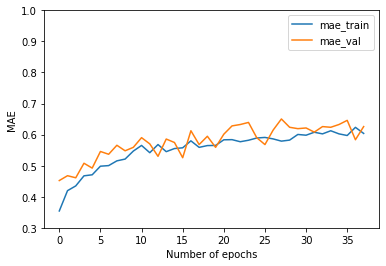

Tester: Segmentation training OK


In [ ]:
# implement your solution BELOW
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\
                                      patience=10, restore_best_weights=True)

history = seg_model.fit_generator(generator=train_seg_generator, validation_data=val_seg_generator,
                steps_per_epoch=32, validation_steps=32, epochs=200, verbose=1,
                callbacks=[earlystopping_callback])

test_loss, test_mae = seg_model.evaluate(x_seg_test, y_seg_test, verbose=1)
print("MAE on test set:", test_mae)

plt.clf()
plt.plot(tr_accs, label="mae_train")
plt.plot(val_accs, label="mae_val")
plt.ylim((0.3, 1.))
plt.xlabel("Number of epochs")
plt.ylabel("MAE")
plt.legend()
plt.show();
    
# implement your solution ABOVE

tester.test('seg_training', test_mae)

###**Q**: Teszthalmaz szegmentációs predikciók kirajzolása

Rajzolj ki néhány **véletlenszerűen választott** képet a teszthalmazból és rajzold ki a hozzájuk becsült maszkokat!

Tester: All tests were successful.


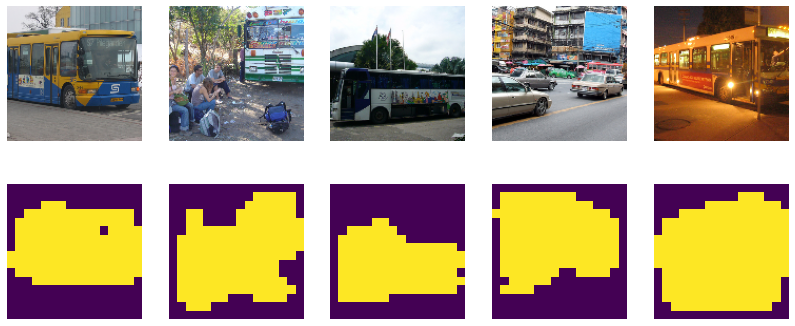

In [ ]:
# implement your solution BELOW
y_seg_pred_test = seg_model.predict(x_seg_test, verbose=0)
selected = np.random.choice(len(x_seg_test), 5)
#print(y_seg_pred_test.shape)
#print(y_seg_pred_test[0])

plt.figure(figsize=(14, 6))
for i, ind in enumerate(selected):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_seg_test[ind])
  plt.axis('off')
  plt.subplot(2, 5, i+6)
  seg_img = y_seg_pred_test[ind].copy().reshape(16,16)
  plt.imshow(np.where(seg_img>0.5, 255, 0))
  plt.axis('off')

# implement your solution ABOVE

tester.print_all_tests_successful()